# Make "red" noise, by specifying the scale for exponential autocorrelation. 

## How do you choose that scale? 
Reasoning: 

Red noise has covariance that drops off exponentially with lag. So if C0 is the variance of the series, and C1 the covariance at a one-step lag, we want to know the value of $\tau_{efold}$ for which $C1/C0 = exp(\delta t / \tau_{efold})$. Solving, $$\tau_{efold} = \delta t /ln(C1/C0) = \delta t /ln(r1)$$ where $r1$ is the *autocorrelation at lag 1.* 

### Work in a pylab session: clean basic tools

In [35]:
# This %pylab magic line loads numpy, scipy, matplotlib. 
# add the word inline to put figures inline
%pylab inline
# plt.xkcd();

Populating the interactive namespace from numpy and matplotlib


From your data (what you are trying to mimic), type 

corrcoef(y, roll(y,1)) 

to see the lag-1 value you need. The function roll(y,1) shifts an array y by one slot periodically. (This is careless about endpoint effects; if your series is short, you should be more careful.) 

In [36]:
# var(y) 
# corrcoef(y, roll(y,1))
# len(y)

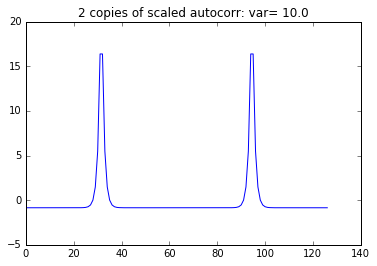

In [37]:
# Let's mimick a data array y, using AR1 red noise. 
# That only depends on autoregression at lag 1 (hence an "AR1 process")

# INPUTS
lag1_autocorr = 0.9  # Read off this value from corrcoef(y, roll(y,1))
variance = 10        # Read off this value from var(y) 
N = 64             # Read off this value from len(y)  



### CALCULATIONS AND PLOTTING
T_efold = 1.0/log(lag1_autocorr) # Units: number of array positions

### MAKE A YAUTO(X) ARRAY WITH THE RIGHT SIZE, VARIANCE, AND SPECTRUM
x = arange(N)              # A simple count array
xpert = x-mean(x)  
yauto = exp(- abs(xpert))  # Autocorrelation
# Scale it to have the given variance
yauto *= sqrt(variance/var(yauto))
# Remove the mean
yauto = detrend(yauto) 

### QUICK PLOT TO SEE IF IT IS SENSIBLE
xx = concatenate([x,x+max(x)])
plot(xx, concatenate([yauto,yauto]))
title('2 copies of scaled autocorr: var='+format(var(yauto),'5.3'));

## Make the complex spectrum, using fft
...normalizing by input series length, since science doesn't want the *values* of spectra to depend on sampling rate (and thus N)

In [38]:
N = len(yauto) 
spec = fft.fft(yauto) /N

# Unpack in all the usual ways: real (cos) and imaginary (sin)
specr = real(spec)
speci = imag(spec)

# Unpack in all the usual ways: amplitude and phase
ampli = abs(spec)
phase = angle(spec)

## Synthesize with smooth red spectrum, random phase. 
Repeated ctrl-enter in the following cell will make one new realization after another to look at. Sobering with respect to monthly climate records in the instrumental era (a few hundred, autocorr = 0.9)

In [39]:
# Edit the spectrum's phase and/or amplitude:
syn_ampli = ampli # No edit to amplitude (power) spectrum for now

# Phase = rand() makes synthetic data
#syn_phase = phase
syn_phase = 2*pi*rand( len(phase) )

# Build the synthetic spectrum from real and imaginary parts
# Synthesize back into physical space (time domain) with ifft: 
# First, we have to rescale by N = len(y). 
# And there is a near-zero imaginary part; strip it off with real()

syn_spec =(    syn_ampli*cos(syn_phase)   #real part
         + 1j* syn_ampli*sin(syn_phase) ) #imag part
syn_data = real( ifft(syn_spec) ) *N 

print 'Variance of synthetic data: ', var(syn_data)

Variance of synthetic data:  4.37420255496


### Notice how scrambling the phase has halved the variance! Let's fix it.

In [40]:
syn_data *= sqrt(2)

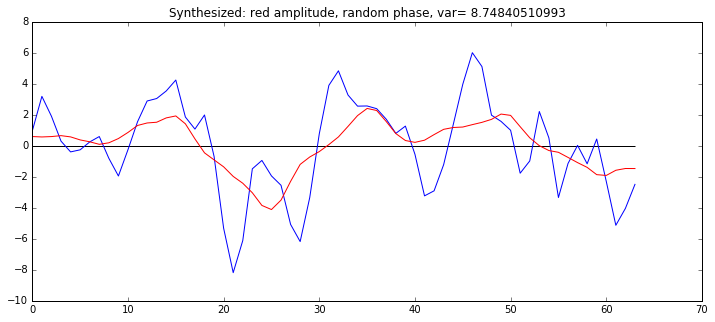

In [41]:
### PLOT the results
figure(6, figsize=[12,5])
yy = tile(syn_data,2)
# plot(xx,yy)
plot(x, syn_data)

# Overplot a smoothed version
kernel = N/10  # to emphasize lowest frequencies
yysmoo = np.convolve(yy, np.ones((10,))/10, mode='same')
ysmoo = np.convolve(syn_data, np.ones((10,))/10, mode='same')

#plot(xx, yysmoo, 'r', linewidth=3)
plot(x, ysmoo, 'r')

title('Synthesized: red amplitude, random phase, var= '+str(var(yy)) );
hlines(0,min(x),max(x));

In [42]:
var(yy)

8.7484051099270808

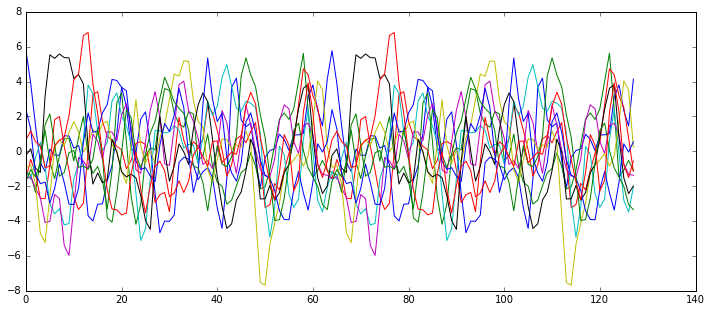

In [43]:
## More realizations with random phases

figure(6, figsize=[12,5])

for i in arange(10): 
    syn_phase = 2*pi*rand( len(phase) )
    
    syn_spec =(    syn_ampli*cos(syn_phase)   #real part
             + 1j* syn_ampli*sin(syn_phase) ) #imag part
    
    syn_data = real( ifft(syn_spec)*N )
    
    plot(tile(syn_data,2)) # two coplies of array

### Plot *spectra* of multiple realizations: copy spectra plot code in above loop

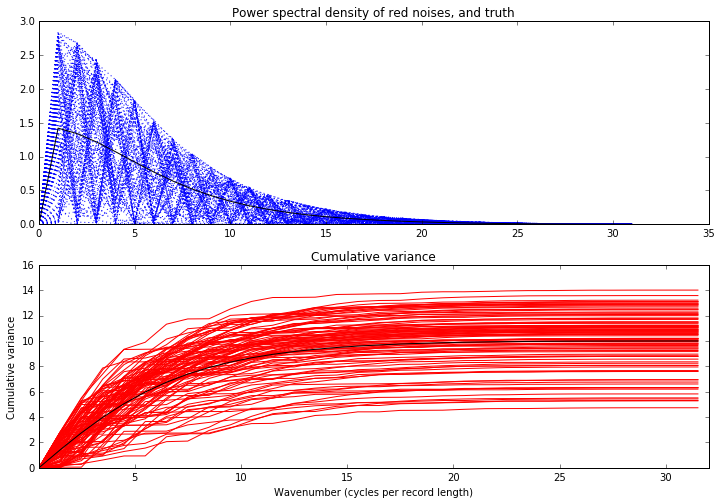

In [44]:
## Spectra of realizations with random phases
figure(7, figsize=[12,8])

## Loop over realizations
for i in arange(100): 
    
# Make synthetic series of right variance 
    syn_phase = 2*pi*rand( len(phase) )
    syn_spec =(    syn_ampli*cos(syn_phase)   #real part
             + 1j* syn_ampli*sin(syn_phase) ) #imag part
    syn_data = real( ifft(syn_spec)*N ) *sqrt(2)

# fft of this one synthetic *realization*
    N = len(syn_data) 
    Wavenumbers = arange(N/2)
    realiz_spec = fft.fft(syn_data) /N
    realiz_ampli = abs(realiz_spec)

# DOUBLE THE VALUEs of half the symmetric spectrum (other than wavenumber 0)
# Power spectrum density is Amplitude squared
# But actually only 0.5x that, since var(sin(x))=var(cos(x))=0.5

    realiz_Amp = realiz_ampli[0:(N/2)] *2.
    realiz_Amp[0] = 0 # zero out the mean of the series
    realiz_Power = (realiz_Amp**2) *0.5

    subplot(211)
    plot(Wavenumbers,realiz_Power   , 'b:')
    title('Power spectral density of red noises, and truth')
    
# Cumulative power graph
    CumWavenum  = concatenate(([-0.5],arange(N/2)+0.5))
    CumVar      = concatenate(([0],   cumsum(realiz_Power) ))
                     
    subplot(212)
    plot(CumWavenum,CumVar,'r')
    xlim([0.5,N/2])
    title('Cumulative variance')
    xlabel('Wavenumber (cycles per record length)')
    ylabel('Cumulative variance');

    
# True spectrum in black, on top of red spaghetti
subplot(211)
Amp = ampli[0:(N/2)] *2.
Amp[0] = 0
Power = (Amp**2) *0.5
plot(Wavenumbers,Power, 'k' );

CumVar      = concatenate(([0],   cumsum(Power) ))
subplot(212)
plot(CumWavenum,CumVar,'k')
